In [103]:
import pandas as pd
import numpy as np
import os
import random
from datetime import datetime

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, auc, RocCurveDisplay,  silhouette_score, classification_report, accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub/prj_on_boarding")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub/prj_on_boarding


In [104]:
p = pd.read_csv("/Users/yj.noh/Desktop/data/partners.csv", encoding = "utf-8")
r = pd.read_csv("/Users/yj.noh/Desktop/data/regions2.csv", encoding = "utf-8")
t = pd.read_csv("/Users/yj.noh/Desktop/data/transactions.csv", encoding = "utf-8")
u = pd.read_csv("/Users/yj.noh/Desktop/data/users.csv", encoding = "utf-8")

print(p.head(), r.head(), t.head(), u.head())

   partner_id onoff_type partner_category      b_code
0           1         ON                D  1171011100
1           2         ON                D  1171011100
2           3         ON                D  1171011100
3           4         ON                S  1168010600
4           5         ON                S  1168010600        b_code   region_nm rgn1_nm rgn2_nm rgn3_nm
0  4215090300   강원 강릉시 교동      강원     강릉시      교동
1  4215011000   강원 강릉시 교동      강원     강릉시      교동
2  4215033000  강원 강릉시 구정면      강원     강릉시     구정면
3  4215012100  강원 강릉시 노암동      강원     강릉시     노암동
4  4215012000  강원 강릉시 담산동      강원     강릉시     담산동    transaction_id  user_id          approved_at  partner_id action_type_cd  \
0            2500    23077  2022-09-01 00:00:21      137370        PAYMENT   
1            2601    42059  2022-09-01 00:00:48       80825        PAYMENT   
2            2810     4339  2022-09-01 00:01:36        5250        PAYMENT   
3            2888    63132  2022-09-01 00:01:53      157580     

In [105]:
print(r.isna().sum())

b_code         0
region_nm      0
rgn1_nm        0
rgn2_nm       17
rgn3_nm      432
dtype: int64


In [106]:
t_u= t.merge(u, on = 'user_id', how = 'left')
t_u_p = t_u.merge(p, on = 'partner_id', how  = 'left')

data = t_u_p.merge(r, on = 'b_code', how = 'left')

print(data.isna().sum())

transaction_id          0
user_id                 0
approved_at             0
partner_id              0
action_type_cd          0
method_type_cd          0
method_amt              0
total_amt               0
gender_cd               0
kr_age                  0
os_cd                   0
join_date               0
last_access_at          0
onoff_type              0
partner_category        0
b_code                  0
region_nm           30818
rgn1_nm             30818
rgn2_nm             30818
rgn3_nm             31474
dtype: int64


In [107]:
num_vars = ['method_amt', 'total_amt', 'kr_age']      
cate_vars = ['method_type_cd', 'onoff_type', 'partner_category']

In [108]:
def plot_numeric (data, numeric_vars, outcome):
        
    palette = 'coolwarm'
    
    for num_var in numeric_vars:
        fig, axs = plt.subplots(1,3, figsize=(16,4))
        fig.suptitle(f'{num_var} 분포', fontsize = 12)
    
        # Boxplot
        sns.boxplot(ax=axs[0], x= outcome, y=num_var, data= data, palette = palette)
        axs[0].set_title('Boxplot')
    
        # Violinplot
        sns.violinplot(ax=axs[1], x = outcome, y = num_var, data = data, palette = palette)
        axs[1].set_title('Violinplot')
        
        # KDE plot
        sns.kdeplot(ax=axs[2], data = data, x = num_var, hue = outcome, fill = True, common_norm = False, palette = palette, alpha=.5, linewidth=0)
        axs[2].set_title('Density plot')
        
        plt.tight_layout()
        fig.subplots_adjust(top=0.8) # title 공간 확보
        
        plt.show()
        plt.close(fig)

In [109]:
def plot_category(data, category_vars, outcome) : 
       
    palette = 'coolwarm'
    
    # 저장할 디렉토리 생성
    os.makedirs('graphs', exist_ok = True)
    
    for cat_var in category_vars : 
        plt.figure(figsize = (12,4))
        ax = sns.countplot(x=cat_var, hue=outcome, data=data, palette=palette)
        plt.title(f'{outcome}에 따른 {cat_var} 분포')
        plt.ylabel('개수')
        plt.legend(title=outcome, loc='upper right')
        plt.xticks(fontsize=8)  # x축 글씨 조정
        
        # 각 막대에 데이터 레이블 추가
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}',  # 높이 값(즉, 개수)을 얻어 텍스트로 설정
                        (p.get_x() + p.get_width() / 2., p.get_height()),  # 텍스트 위치 설정
                        ha='center',  # 가로 정렬(center)
                        va='center',  # 세로 정렬(center)
                        xytext=(0, 10),  # 텍스트 오프셋(위쪽으로 약간 이동)
                        textcoords='offset points',  # 어떤 종류의 오프셋을 사용할지 정의
                        fontsize=10)  # 글꼴 크기
        
        plt.tight_layout()
        plt.show()
     

In [ ]:
# plot_numeric(data, num_vars, 'gender_cd')
# plot_category(data, cate_vars, 'gender_cd') 

In [111]:
# 성별 기준으로? 이탈 값 제거 

def remove_outliers(df, column, grouping):
    Q1 = df.groupby(grouping)[column].quantile(0.25)
    Q3 = df.groupby(grouping)[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[df.apply(lambda x: (x[column] >= lower_bound[x[grouping]]) & 
                                 (x[column] <= upper_bound[x[grouping]]), axis=1)]

data_rm = remove_outliers(data, 'method_amt', 'gender_cd')
data_rm = remove_outliers(data_rm, 'total_amt', 'gender_cd')
print(data_rm.shape) #393,850

(393850, 20)


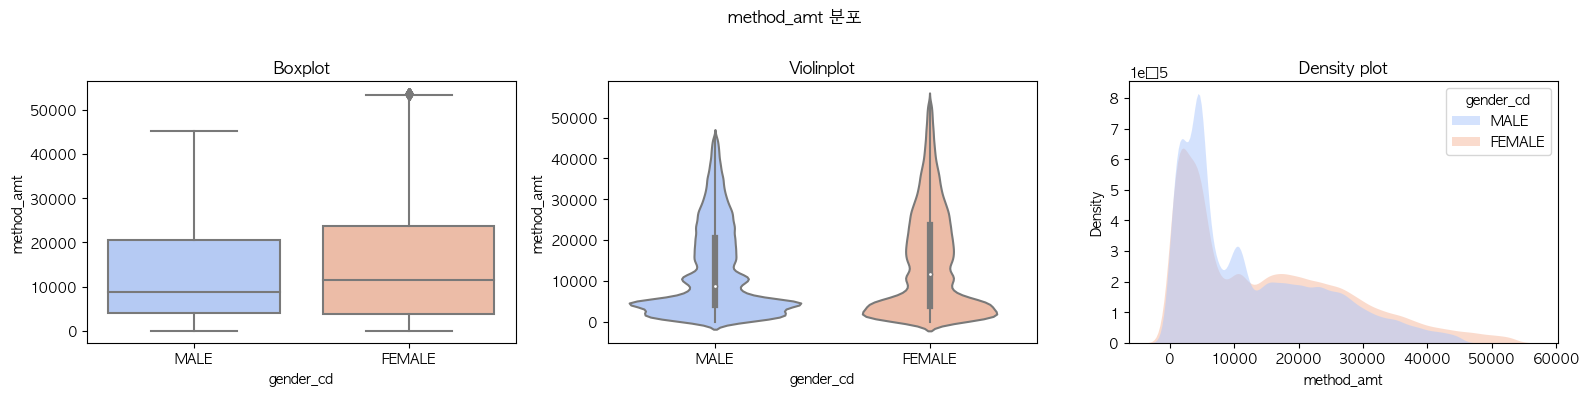

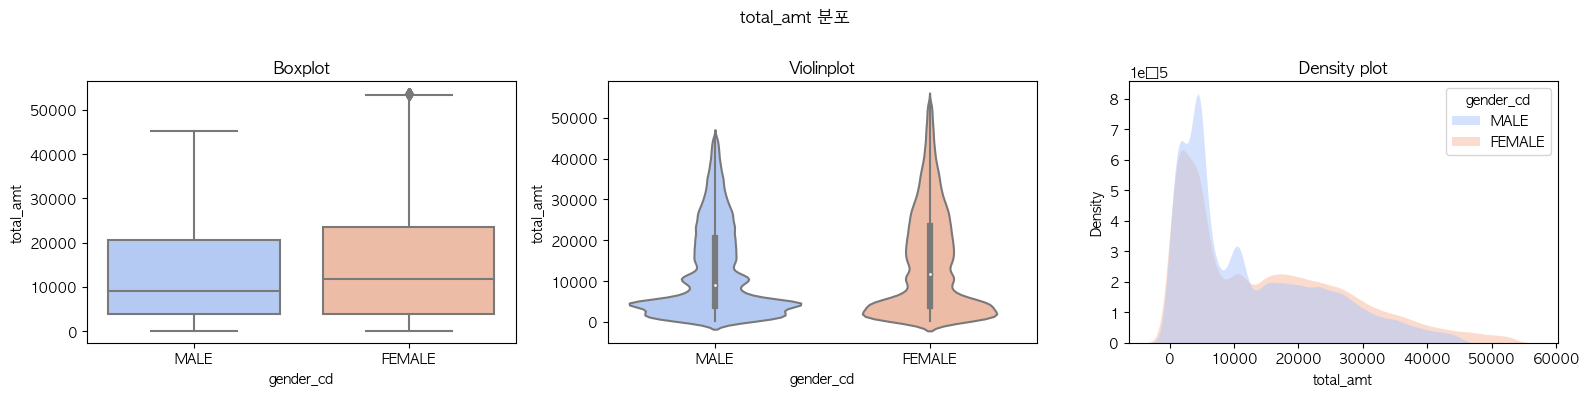

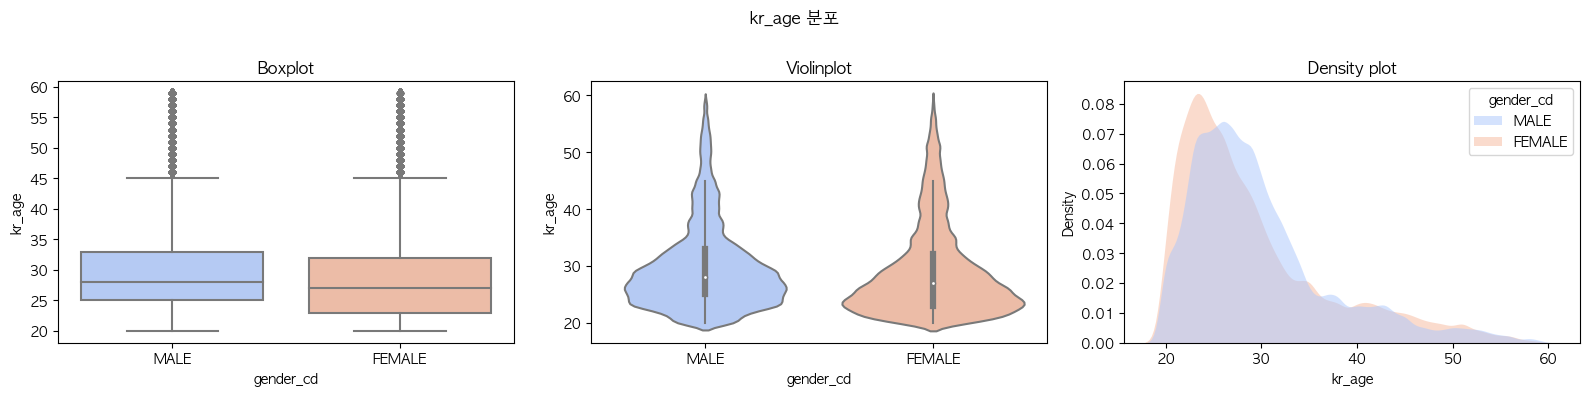

In [112]:
plot_numeric(data_rm, num_vars, 'gender_cd')

In [113]:
print(data_rm.head(2))

   transaction_id  user_id          approved_at  partner_id action_type_cd  \
0            2500    23077  2022-09-01 00:00:21      137370        PAYMENT   
1            2601    42059  2022-09-01 00:00:48       80825        PAYMENT   

  method_type_cd  method_amt  total_amt gender_cd  kr_age    os_cd  \
0          MONEY         800        800      MALE      24  Android   
1           CARD        4400       4400    FEMALE      24  Android   

    join_date       last_access_at onoff_type partner_category      b_code  \
0  2018-03-10  2023-05-06 02:00:14        OFF                C  4121010300   
1  2020-06-17  2023-05-07 14:36:22        OFF                C  1168010700   

    region_nm rgn1_nm rgn2_nm rgn3_nm  
0  경기 광명시 하안동      경기     광명시     하안동  
1  서울 강남구 신사동      서울     강남구     신사동  


In [114]:
print(data_rm['approved_at'].min()) #2022-09-01
print(data_rm['approved_at'].max()) #2022-11-30 

2022-09-01 00:00:21
2022-11-30 23:59:42


In [115]:
# user_id별로 3개월동안 결제 횟수, 평균 결제 주기, 평균 결제 금액 산출
data_rm['approved_at'] = pd.to_datetime(data_rm['approved_at'])

# 결제 횟수
transaction_counts = data_rm.groupby('user_id')['transaction_id'].count().reset_index(name='결제횟수')

# 사용자별 결제 간 시간 간격 계산
data_rm = data_rm.sort_values(['user_id', 'approved_at'])
data_rm['previous_access'] = data_rm.groupby('user_id')['approved_at'].shift(1)
data_rm['interval'] = (data_rm['approved_at'] - data_rm['previous_access']).dt.days #일자 

# 각 사용자별 평균 결제 간격 계산
average_intervals = data_rm.groupby('user_id')['interval'].mean().reset_index(name='평균결제주기')

# 평균 결제 금액 계산
average_amount = data_rm.groupby('user_id')['method_amt'].mean().reset_index(name='평균결제금액')

# 마지막 결제 일자
max_transaction_date = data_rm.groupby('user_id')['approved_at'].max().reset_index(name = '마지막결제일자')

# total! 
from functools import reduce
dfs = [transaction_counts, average_intervals, average_amount, max_transaction_date]
user_summary = reduce(lambda left, right: pd.merge(left, right, on='user_id'), dfs)

print(user_summary.head())


   user_id  결제횟수    평균결제주기        평균결제금액             마지막결제일자
0        4     3  1.500000  19300.000000 2022-10-23 16:16:50
1        7    24  2.782609  23983.333333 2022-11-22 22:19:49
2       10     3  5.500000  33000.000000 2022-11-10 11:43:08
3       11    17  4.437500  19717.647059 2022-11-20 17:04:58
4       12    11  8.000000   5836.363636 2022-11-27 01:12:19


In [116]:
user_summary = user_summary.merge(u, on = 'user_id', how = 'right')
print(user_summary.head())

   user_id  결제횟수  평균결제주기   평균결제금액             마지막결제일자 gender_cd  kr_age  \
0        1   NaN     NaN      NaN                 NaT      MALE      29   
1        2   NaN     NaN      NaN                 NaT    FEMALE      48   
2        3   NaN     NaN      NaN                 NaT      MALE      28   
3        4   3.0     1.5  19300.0 2022-10-23 16:16:50    FEMALE      28   
4        5   NaN     NaN      NaN                 NaT      MALE      40   

     os_cd   join_date       last_access_at  
0      iOS  2017-04-02  2023-05-04 22:09:24  
1  Android  2017-04-03  2023-05-06 11:49:54  
2      iOS  2017-04-02  2023-05-06 17:45:42  
3  Android  2017-04-02  2023-05-05 07:33:01  
4      iOS  2017-04-03  2023-05-08 01:09:07  


In [117]:
# 마지막 결제일 ~ 가입일사이의 기간
user_summary['join_date'] = pd.to_datetime(user_summary['join_date'])
user_summary['마지막결제일자'] = pd.to_datetime(user_summary['마지막결제일자'])

def month_diff(row):
    join_date = row['join_date']
    last_payment_date = row['마지막결제일자']
    
    diff = (last_payment_date.year - join_date.year) * 12 + last_payment_date.month - join_date.month
    return diff


user_summary['period_join'] = user_summary.apply(month_diff, axis=1)
print(user_summary.head())


   user_id  결제횟수  평균결제주기   평균결제금액             마지막결제일자 gender_cd  kr_age  \
0        1   NaN     NaN      NaN                 NaT      MALE      29   
1        2   NaN     NaN      NaN                 NaT    FEMALE      48   
2        3   NaN     NaN      NaN                 NaT      MALE      28   
3        4   3.0     1.5  19300.0 2022-10-23 16:16:50    FEMALE      28   
4        5   NaN     NaN      NaN                 NaT      MALE      40   

     os_cd  join_date       last_access_at  period_join  
0      iOS 2017-04-02  2023-05-04 22:09:24          NaN  
1  Android 2017-04-03  2023-05-06 11:49:54          NaN  
2      iOS 2017-04-02  2023-05-06 17:45:42          NaN  
3  Android 2017-04-02  2023-05-05 07:33:01         66.0  
4      iOS 2017-04-03  2023-05-08 01:09:07          NaN  


In [128]:
# 이탈 여부 (결제 횟수 na or 마지막 결제일자~11/30 사이 기간 > 평균결제주기)
reference_date = pd.to_datetime('2022-11-30')

def check_churn(row):
    if pd.isna(row['결제횟수']):
        return 1
    days_since_last_purchase = (reference_date - row['마지막결제일자']).days
    if days_since_last_purchase > row['평균결제주기']:
        return 1
    return 0

user_summary['이탈'] = user_summary.apply(check_churn, axis=1)

print(user_summary.shape)
print(user_summary['이탈'].value_counts())


(64210, 13)
이탈
1    46405
0    17805
Name: count, dtype: int64


In [127]:
print(u.shape)

(64210, 6)


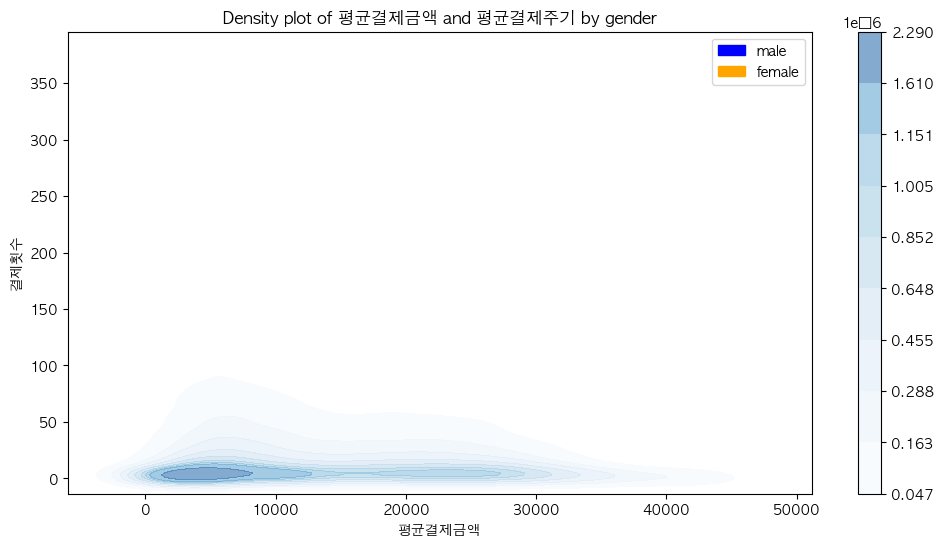

In [129]:
man = user_summary[user_summary['gender_cd'] == 'MALE']
female  = user_summary[user_summary['gender_cd'] == 'FEMALE']

plt.figure(figsize=(12, 6))

sns.kdeplot(data = man, x='평균결제금액', y='결제횟수', cmap='Blues', shade=True, alpha=0.5, cbar=True)
sns.kdeplot(data = female, x='평균결제금액', y='평균결제주기', cmap='Oranges', shade=True, alpha=0.5, cbar=True, thresh=0.05)

plt.xlabel('평균결제금액')
plt.ylabel('결제횟수')
plt.title('Density plot of 평균결제금액 and 평균결제주기 by gender')

# Manual legend
blue_patch = mpatches.Patch(color='blue', label='male')
orange_patch = mpatches.Patch(color='orange', label='female')
plt.legend(handles=[blue_patch, orange_patch])

plt.show()

In [131]:
conditions = [
    user_summary['period_join'] < 6,
    user_summary['period_join'] < 12,
    user_summary['period_join'] < 18,
    user_summary['period_join'] < 24,
    user_summary['period_join'] >= 24
]

labels = ['6개월 미만', '6-12개월', '12-18개월', '18-24개월', '24개월이상']
user_summary['join_month'] = np.select(conditions, labels, default='정보없음')

print(user_summary['join_month'].value_counts())

join_month
정보없음       35440
24개월이상     27788
18-24개월      538
12-18개월      307
6-12개월       110
6개월 미만        27
Name: count, dtype: int64


In [138]:
# 이탈 + 가입기간
churn_crosstab = pd.crosstab( user_summary['이탈'], user_summary['join_month'])
churn_crosstab = churn_crosstab[labels]
print(churn_crosstab.columns)

churn_crosstab

Index(['6개월 미만', '6-12개월', '12-18개월', '18-24개월', '24개월이상'], dtype='object', name='join_month')


join_month,6개월 미만,6-12개월,12-18개월,18-24개월,24개월이상
이탈,,,,,
0,16,71,166,322,17230
1,11,39,141,216,10558


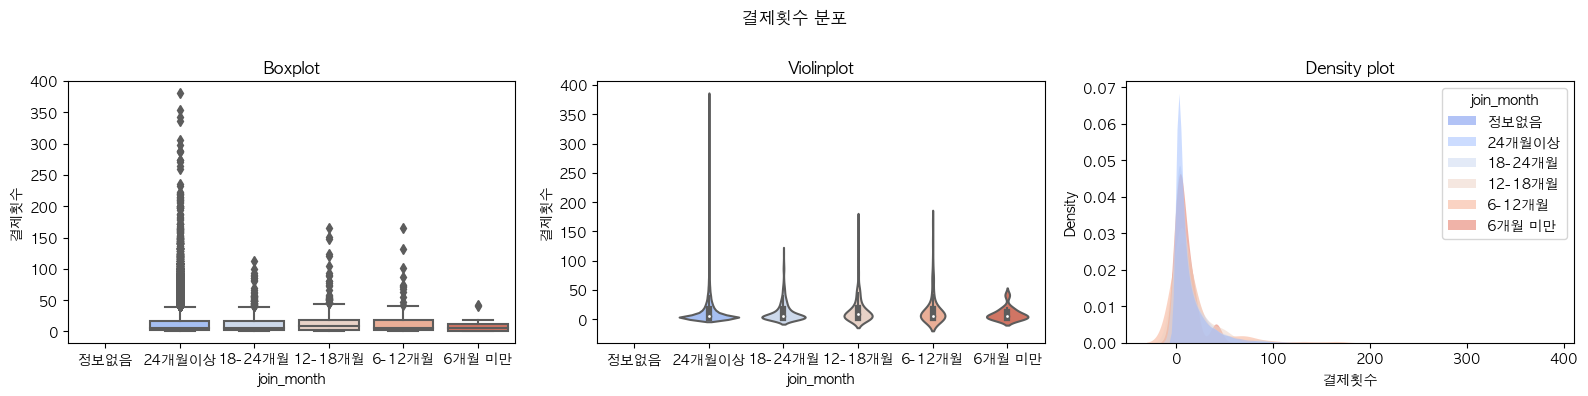

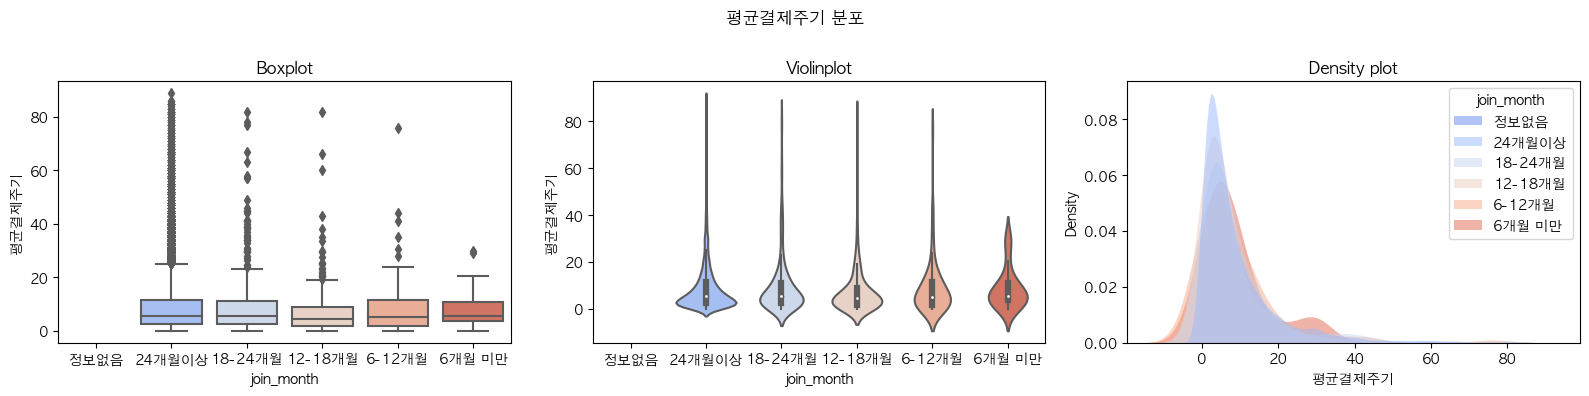

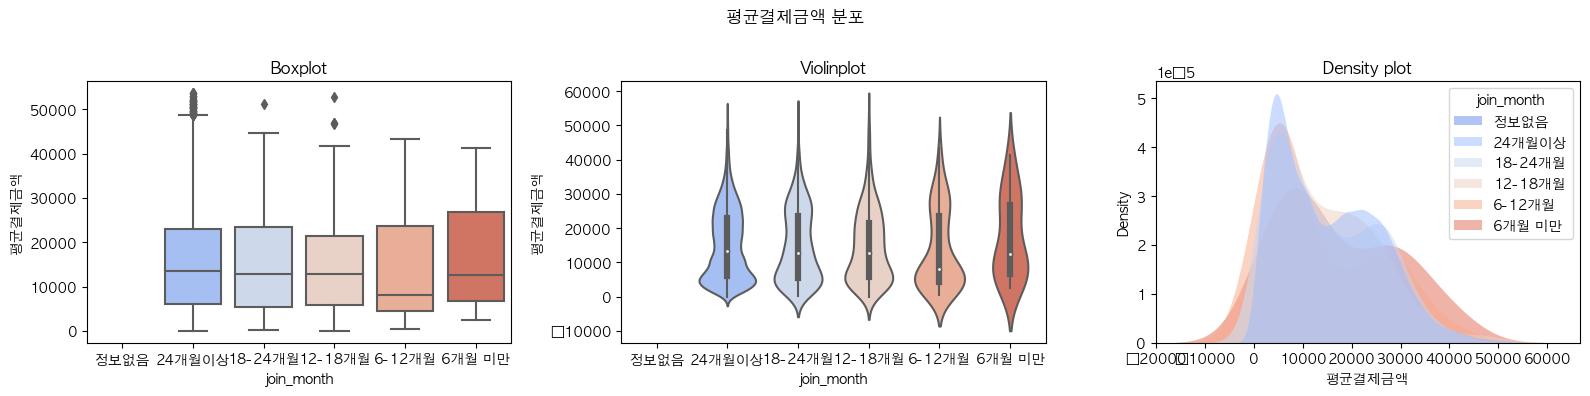

In [121]:
numeric = ['결제횟수' ,'평균결제주기' , '평균결제금액']
plot_numeric(user_summary, numeric, 'join_month')

In [122]:
# 3개월 내 이탈한 라이더는 누구인가


In [123]:
# 어떤 인코딩이 되는지 체크하기 
# import chardet    

# # 인코딩 확인을 위한 함수
# def detect_file_encoding(file_path):
#     with open(file_path, 'rb') as f:
#         result = chardet.detect(f.read())
#     return result['encoding']

# # 파일 경로
# file_paths = ["/Users/yj.noh/Desktop/data/partners.csv", "/Users/yj.noh/Desktop/data/regions2.csv", 
#               "/Users/yj.noh/Desktop/data/transactions.csv", "/Users/yj.noh/Desktop/data/users.csv"]

# # 각 파일의 인코딩 확인
# for file_path in file_paths:
#     encoding = detect_file_encoding(file_path)
#     print(f"File: {file_path}, Encoding: {encoding}")

In [124]:
# 이것저것 시도 후 파일 로드 
# def try_encodings(file_path):
#     # 시도해 볼 인코딩 목록
#     encodings = ['utf-8', 'ISO-8859-1', 'cp1252', 'latin1', 'cp949']
    
#     for enc in encodings:
#         try:
#             # 시도해 볼 때마다 파일을 로드
#             df = pd.read_csv(file_path, encoding=enc)
#             print(f"File: {file_path} loaded successfully with encoding: {enc}")
#             return df
#         except Exception as e:
#             # 인코딩 실패 시 출력
#             print(f"Error using {enc} for {file_path}: {e}")
    
#     # 모든 인코딩 시도 후 여전히 실패한 경우
#     raise ValueError(f"Unable to load file: {file_path}, tried encodings: {encodings}")

# # 파일 경로
# file_paths = ["/Users/yj.noh/Desktop/data/partners.csv", "/Users/yj.noh/Desktop/data/regions2.csv", 
#               "/Users/yj.noh/Desktop/data/transactions.csv", "/Users/yj.noh/Desktop/data/users.csv"]

# # 파일 로드 시도
# dataframes = {}
# for file_path in file_paths:
#     file_name = file_path.split("/")[-1].split(".")[0]  # 파일명 추출
#     dataframes[file_name] = try_encodings(file_path)  # 로드된 데이터프레임 저장
